In [1]:
# Se importan las librerias que se van a utilizar
import pandas as pd
import numpy as np
import talib
import time
import matplotlib.pyplot as plt

In [2]:
# Se elige el PAR
PAIR = 'USDJPY' 

# Lee el archivo CSV
df = pd.read_csv(f"data/{PAIR}/{PAIR}_Candlestick_5_m_BID_01.01.2023-31.07.2023.csv", sep="," )

# Se renombra las columnas del DataFrame
df.columns = ["DateTime", "Open", "High", "Low", "Close", "Volume"]

# Se eliminan los valores NaN
df = df.dropna(subset=['Close'], how='any')

# Se seleccionan los datos con volumen
df_filtered = df[df['Volume'] != 0]

# Se carga en HISTORICAL_DATA_AUX 
historical_data_aux = df_filtered.reset_index(drop=True).copy()

# Los primeros 320 datos se usan para calculos posteriores, como el VAR, o las operaciones de entramiento, por eso se tienen que quitar esos primeros datos
historical_data = historical_data_aux[320:]
historical_data.reset_index(drop=True, inplace=True)
historical_data.head()

,DateTime,Open,High,Low,Close,Volume
0,03.01.2023 00:50:00.000,130.723,130.741,130.639,130.639,949.91
1,03.01.2023 00:55:00.000,130.639,130.642,130.570,130.606,984.92
2,03.01.2023 01:00:00.000,130.612,130.677,130.612,130.659,1078.22
3,03.01.2023 01:05:00.000,130.659,130.714,130.578,130.628,1477.32
4,03.01.2023 01:10:00.000,130.626,130.630,130.198,130.209,2890.75


De todos los datos se han quitado los primeros 320 datos, y esto es para usarlos para calcular el VaR (Valor en Riesgo o Value at Risk). Se tienen dos series data_var_aux y data_var, la primera serie es para el modelo posterior de machine learning, pues al hacer una serie de lags la serie se queda con los 19 valores como NaN, y la segunda serie data_var ya contiene esos 301 datos, es decir la aux sirve para el modelo de ML, simplemente para tener el mismo número de datos en ambas series.

In [3]:
# Datos para calcular los primeros valores para VaR
data_var_aux = historical_data_aux.head(320) # Para el modelo de ML para coger los primeros 20 datos 
# Porque luego se hacen lags y se queda en NaN
data_var = data_var_aux[19:]
data_var.reset_index(drop=True, inplace=True)
data_var

,DateTime,Open,High,Low,Close,Volume
0,01.01.2023 23:40:00.000,130.799,130.870,130.798,130.870,31.50
1,01.01.2023 23:45:00.000,130.870,130.870,130.849,130.850,13.50
2,01.01.2023 23:50:00.000,130.852,130.853,130.849,130.849,18.00
3,01.01.2023 23:55:00.000,130.849,130.886,130.848,130.870,31.80
4,02.01.2023 00:00:00.000,130.886,130.916,130.871,130.916,21.60
...,...,...,...,...,...,...
296,03.01.2023 00:25:00.000,130.808,130.828,130.778,130.802,946.32
297,03.01.2023 00:30:00.000,130.802,130.803,130.737,130.757,851.79
298,03.01.2023 00:35:00.000,130.761,130.761,130.608,130.696,1072.57
299,03.01.2023 00:40:00.000,130.698,130.709,130.616,130.659,883.54


In [10]:
start_time = time.time()

### Se inicializan las variables
close_data = historical_data['Close']
rsi_data = talib.RSI(close_data, timeperiod=14) # devuelve una serie de pandas
sell_threshold = 70 # Limites para el RSI
buy_threshold = 30 # Limites para el RSI
position = 0 # Posicion incial
entry_price = 0 # Precio inicial a 0
signals = []
initial_balance = 100000
balance = initial_balance # Balance inicial que se irá actualizando
pip = 0.01
stop_loss = 10*pip # Se define un SL fijo
take_profit = 20*pip # Igual con el TP es fijo
risk = 1 # Se define el riesgo como el 1% de balance
transactions = pd.DataFrame(columns=['Date','Action','Price']) # Se guardaran todas las transacciones
position_history = pd.DataFrame(columns=['Date','Position']) # Aqui se guardara todo el resgitro de los distintos movimientos
balance_history = pd.DataFrame(columns=['DateTime','Balance_history','Action']) # Aqui se llevará el registro del balance

# Inicia el balance
balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[0]],'Balance_history':[balance],'Action': ['Start']})], ignore_index=True)

#   0 - Fuera del mercado
#   1 - Compra
#  -1 - Venta
#   2 - SL Compra
#  -2 - SL Venta
#   3 - TP Compra
#  -3 - TP Venta
#  10 - Hold de compra 
# -10 - Hold de Venta
#  22 - Operación de compra cerrada en pérdida 
# -22 - Operación de venta cerrada en pérdida
#  33 - Operación de compra cerrada en ganancia 
# -33 - Operación de venta cerrada en ganancia

# Aqui iran los datos para realizar el calculo del VaR
change = data_var['Close']
change.reset_index(drop=True)

### Estrategia de Trading ###
for i in range(len(close_data)):
    
    # Se actualiza la serie change con el valor de close_data[i]
    # Se elimina el dato más viejo en CHANGE (primer dato)
    change = change.iloc[1:].reset_index(drop=True)
    # Se agrega el nuevo dato (close_data.iloc[i]) al final de CHANGE
    change = change.append(pd.Series(close_data.iloc[i])).reset_index(drop=True)
    
    # Se calcula el rendimiento continuo
    data_RCont = np.log(change/change.shift(1))
    data_RCont = data_RCont.dropna()
    # Se calcula el VaR_buy
    alpha_buy = 0.05
    t = 1
    VaR_buy = (np.quantile(data_RCont, alpha_buy))*np.sqrt(t)
    # Se calcula el VaR_sell
    alpha_sell = 0.95
    VaR_sell = (np.quantile(data_RCont, alpha_sell))*np.sqrt(t)
    
    # Si se está fuera de mercado (0), o en TP (3,-3) o en SL (2,-2) entonces:
    if position in [0, 2, 3, -2, -3, 22, 33, -22, -33]:
        # Si se cumple la condición se entra en COMPRA
        if rsi_data.iloc[i] <= buy_threshold:
            # SE ENTRA EN COMPRA
            # Se define la posición en Compra, y se marca en position, en signals, y se marca el precio de entrada
            position = 1
            signals.append(1)
            entry_price = close_data.iloc[i]
            
            # Se coloca SL y TP           
            stop_loss_price = round((float(entry_price) - stop_loss),3)
            take_profit_price = round((float(entry_price) + take_profit),3)
            
            # Se guarda el registro
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Buy'], 'Price': [entry_price]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [1]})], ignore_index=True)

        # Si se cumple la condición se entra en VENTA
        elif rsi_data.iloc[i] >= sell_threshold:
            # SE ENTRA EN VENTA
            # Se define la posición en Venta, y se marca en position, en signals, y el precio de entrada
            position = -1 
            signals.append(-1)
            entry_price = close_data.iloc[i]
            
            # Se coloca SL y TP
            stop_loss_price = round((float(entry_price) + stop_loss),3)
            take_profit_price = round((float(entry_price) - take_profit),3)
            
            # Se guarda el registro
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Sell'], 'Price': [entry_price]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [-1]})], ignore_index=True)

        # Si no se cumple ni compra ni venta entonces se mantiene fuera de mercado (0)
        else:
            position = 0
            signals.append(0) 
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Outside_market'], 'Price': [0]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [0]})], ignore_index=True)

    # Si se está en COMPRA, se cierra la posición con take_profit, o bien se cierra por VaR, o stop_loss, y si no se mantiene
    elif position in [1, 10]:
        # Take Profit de Compra
        if float(close_data.iloc[i]) >= take_profit_price:
            # Se actualiza el balance, position, transactions y position_history
            balance = (initial_balance*(risk*2/100)) + balance
            balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Take_Profit_Long']})], ignore_index=True)
            position = 3
            signals.append(3)
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Take_Profit_Long'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [3]})], ignore_index=True)

        # Aqui entra Value at Risk
        elif data_RCont.iloc[-1] <= VaR_buy:
            if float(entry_price) <= float(close_data.iloc[i]):
                # Beneficio
                last_pips = (float(close_data.iloc[i]) - float(entry_price)) / pip
                last_risk = (last_pips*risk) / (stop_loss/pip)
                balance = (initial_balance*(last_risk/100)) + balance
                balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Positive_Close_VaR_buy']})], ignore_index=True)
                position = 33
                signals.append(33)
                transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Take_Profit_VaR_Buy'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
                position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [33]})], ignore_index=True)
            else:
                # Perdida
                last_pips = (float(entry_price) - float(close_data.iloc[i])) / pip
                last_risk = (last_pips*risk) / (stop_loss/pip)
                balance = (initial_balance*(last_risk/100)) + balance
                balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Negative_Close_VaR_buy']})], ignore_index=True)
                position = 22
                signals.append(22)
                transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Stop_Loss_VaR_Buy'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
                position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [22]})], ignore_index=True)
        
        # Stop Loss de Compra
        elif float(close_data.iloc[i]) <= stop_loss_price:
            # Se actualiza el balance, position, transactions y position_history
            balance = (initial_balance*(risk*(-1)/100)) + balance
            balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Stop_Loss_Long']})], ignore_index=True)
            position = 2
            signals.append(2)
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Stop_Loss_Long'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [2]})], ignore_index=True)
        
        # Se mantiene la compra
        else:
            position = 10
            signals.append(10)
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Hold_Buy'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [10]})], ignore_index=True)
            
    # Si se está en VENTA, se cierra la posición con take_profit, o bien se cierra por VaR, o stop_loss, si no se mantiene
    elif position in [-1, -10]:
        # Take Profit de Venta
        if float(close_data.iloc[i]) <= take_profit_price:
            # Se actualiza el balance, position a -3, transactions y position_history
            balance = (initial_balance*(risk*2/100)) + balance
            balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Take_Profit_Short']})], ignore_index=True)
            position = -3
            signals.append(-3)
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Take_Profit_Short'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [-3]})], ignore_index=True)
        
        # Aqui entra Value at Risk
        elif data_RCont.iloc[-1] >= VaR_sell: 
            if float(entry_price) >= float(close_data.iloc[i]):
                # Beneficio
                last_pips = (float(close_data.iloc[i]) - float(entry_price)) / pip
                last_risk = (last_pips*risk) / (stop_loss/pip)
                balance = (initial_balance*(last_risk/100)) + balance
                balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Positive_Close_VaR_sell']})], ignore_index=True)
                position = -33
                signals.append(-33)
                transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Take_Profit_VaR_Sell'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
                position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [-33]})], ignore_index=True)
            else:
                # Perdida
                last_pips = (float(entry_price) - float(close_data.iloc[i])) / pip
                last_risk = (last_pips*risk) / (stop_loss/pip)
                balance = (initial_balance*(last_risk/100)) + balance
                balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Negative_Close_VaR_sell']})], ignore_index=True)
                position = -22
                signals.append(-22)
                transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Stop_Loss_VaR_Sell'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
                position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [-22]})], ignore_index=True)
        
        # Stop Loss de Venta
        elif float(close_data.iloc[i]) >= stop_loss_price:
            # Se actualiza el balance, position a -2, transactions y position_history
            balance = (initial_balance*(risk*(-1)/100)) + balance
            balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Stop_Loss_Short']})], ignore_index=True)
            position = -2
            signals.append(-2)
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Stop_Loss_Short'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [-2]})], ignore_index=True)
        
        # Se mantiene la venta
        else:
            position = -10
            signals.append(-10)
            transactions = pd.concat([transactions, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Action': ['Hold_Sell'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'Date': [historical_data.DateTime.iloc[i]], 'Position': [-10]})], ignore_index=True)

# Se termina el bucle for, hay que cerrar la posición por si se ha quedado alguna operación abierta
# Si acaba de tocar TP o SL, solo es poner position a 0
if position in [2, 3, -2, -3, 22, 33, -22, -33]:
    position = 0

# Si está en compra
elif position in [1, 10]:
    position = 0
    # Se mira la diferencia de pips entre el precio de entrada y el precio actual (último precio) y se divide entre 1 pip, para obtener los pips totales que hay de diferencia
    last_pips = (float(close_data.iloc[-1]) - float(entry_price)) / pip
    # Como se tiene el riesgo (risk que es de 1%) ese es el SL, es decir en este caso es un risk de 1% para 10 pips eso es lo que se ha definido
    # Se saca la relación para ver el riesgo que se tiene para los pips obtenidos
    last_risk = (last_pips*risk) / (stop_loss/pip)
    # Aqui se añade al balance, el last_risk será o negativo o positivo
    balance = (initial_balance*(last_risk/100)) + balance
    
    balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Positive_manual_closing']})], ignore_index=True)
    
# Si está en venta
elif position in [-1, -10]:
    position = 0
    last_pips = (float(entry_price) - float(close_data.iloc[-1])) / pip
    last_risk = (last_pips*risk) / (stop_loss/pip)
    balance = (initial_balance*(last_risk/100)) + balance
    balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Negative_manual_closing']})], ignore_index=True)   

# Se cuenta el número de ocurrencias de cada tipo de entrada
tp_count = signals.count(3) + signals.count(-3)
sl_count = signals.count(2) + signals.count(-2)
buy_count = signals.count(1)
sell_count = signals.count(-1)

VaR_profit = signals.count(33) + signals.count(-33)
VaR_loss = signals.count(22) + signals.count(-22)

win_rate = round((tp_count + VaR_profit) / (tp_count + sl_count + VaR_profit + VaR_loss) * 100,2)

# Se crea el DataFrame con los resultados
summary_df = pd.DataFrame({
    'Balance': [balance],
    'Buy': [buy_count],
    'Sell': [sell_count],
    'Take_Profit': [tp_count],
    'Stop_Loss': [sl_count],
    'VaR_profit': [VaR_profit],
    'VaR_loss': [VaR_loss],
    'Win_Rate': [win_rate]
})

# Se fija como index el DateTime en balance_history
balance_history = balance_history.set_index('DateTime')

end_time = time.time()
execution_time = end_time - start_time

print("Tiempo de ejecución:", execution_time, "segundos")

Tiempo de ejecución: 203.3129141330719 segundos


In [11]:
summary_df

,Balance,Buy,Sell,Take_Profit,Stop_Loss,VaR_profit,VaR_loss,Win_Rate
0,617190.0,620,665,351,230,129,574,37.38


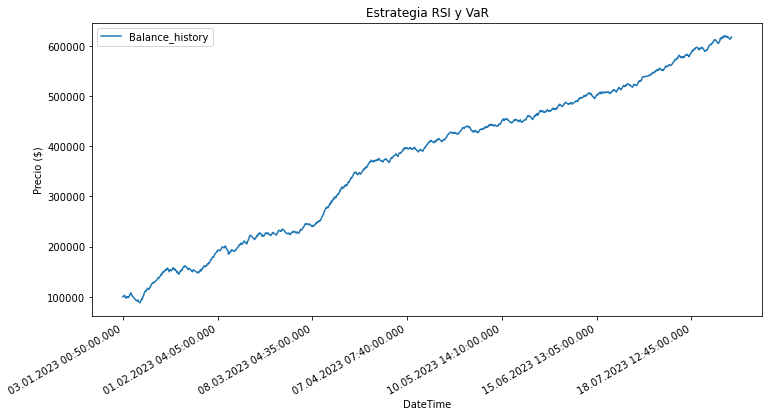

In [12]:
# Crear una figura más grande
plt.figure(figsize=(12, 6))  

# Trazar el gráfico
balance_history['Balance_history'].plot(title="Estrategia RSI y VaR")

# Agregar etiqueta al eje y
plt.ylabel('Precio ($)')

# Rotar automáticamente las etiquetas de fecha
plt.gcf().autofmt_xdate()

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()